## <b> Setup <b/>

### <b> Colab <b/>

In [1]:
colab = False

if colab:
    
    ### Install packages

    !pip3 install tensorflow-text
    !pip3 install tf-models-official
    !pip3 install transformers
    !pip3 install datasets
    !pip3 install swifter
    !pip3 install opencc-python-reimplemented

    ### Access Google Drive

    from google.colab import drive
    drive.mount('/content/gdrive')

    ### Access GCS

    from google.colab import auth
    auth.authenticate_user()

    ### Mount the directories

    import os

    # Mount the data directory
    os.chdir('/content/gdrive/MyDrive/LinuxServer-Bob/Code/Project/Text_Sentimentor/sentimentor')
    os.symlink('/content/gdrive/MyDrive/LinuxServer-Bob/Data', '/data')
    print(f"PWD: {os.getcwd()}")

    # Mount the tfrecord directory
    gcs_path = "gs://bobscchien-project-data"
    
    ### Check the computation resources

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

### <b> Initialization <b/>

In [2]:
from utils.initialization import *
from utils.tokenizer import *
from utils.dataset_tfrecord import *
from utils.servitization import *
from utils.visualization import *
from models.transformer_bert import *

2021-11-21 08:32:09.752033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-21 08:32:09.752087: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Directory /data exists.
Directory /data/Model_Tensorflow exists.
Directory /data/Model_Pytorch exists.
Directory /data/Text_Tokenizer/vocab exists.
Directory /data/Text_Tokenizer/trained exists.
Directory /data/Text_Sentimentor/dataset exists.
Directory /data/Text_Sentimentor/datatf exists.
Directory /data/Text_Sentimentor/model/savedmodels exists.
Directory /data/Text_Sentimentor/model/checkpoints exists.
Directory /data/Text_Sentimentor/model/logs exists.
Directory /data/Text_Sentimentor/tmp exists.

Running on CPU...

Your runtime has 101.1 gigabytes of available RAM

You are using a high-RAM runtime!


2021-11-21 08:32:13.278804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-21 08:32:13.278907: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-21 08:32:13.278938: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-11-21 08:32:13.340666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
if colab:
    DIR_VOCAB       = os.path.join(gcs_path, 'Text_Tokenizer', 'vocab')
    DIR_TOKEN       = os.path.join(gcs_path, 'Text_Tokenizer', 'trained')

    DIR_TFRECORD    = os.path.join(gcs_path, PROJECT_NAME, 'datatf')
    DIR_MODEL       = os.path.join(gcs_path, PROJECT_NAME, 'model', 'savedmodels')
    DIR_CHECKPOINT  = os.path.join(gcs_path, PROJECT_NAME, 'model', 'checkpoints')
    DIR_LOG         = os.path.join(gcs_path, PROJECT_NAME, 'model', 'logs')

### <b> Parameters <b/>

In [4]:
### Tokenization Method

### Language Pair

lang_pair = ('en', '')
lang_prefix = f"{lang_pair[0].upper()}_"
inp_lang, tar_lang = lang_pair

### Preprocessor

text_preprocessors = {'inp':en_preprocess, 'tar':None}

### Global Variables

MAX_LENGTHS = {'inp':256, 'tar':None}

In [5]:
### Definition of Bert Model

bert_names = {'inp':BERT_NAMES[inp_lang]['bert'][0],
              'tar':None}
cache_dirs = {'inp':os.path.join(DIR_MODELTORCH, bert_names['inp']),
              'tar':None}

print(f"Using Pretrained Bert Model: {bert_names}")
print(f"Cache Directory of Model: {cache_dirs}")
print(f"\nMax Length of Text: {MAX_LENGTHS}")

Using Pretrained Bert Model: {'inp': 'bert-base-uncased', 'tar': None}
Cache Directory of Model: {'inp': '/data/Model_Pytorch/bert-base-uncased', 'tar': None}

Max Length of Text: {'inp': 256, 'tar': None}


## <b> 1. Download Dataset <b/>
#### <i> IMDB Dataset <i/>

In [6]:
dataset_name = 'imdb'

In [7]:
### Download the dataset and record the path

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir=DIR_DATA, cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(dataset_dir, 'train', 'unsup')
shutil.rmtree(remove_dir)

In [8]:
def read_sentiment_dataset(data_dir, label_dict, preprocessor=None):
    data_dir = pathlib.Path(data_dir)
    
    texts, labels = [], []
    for label_dir in label_dict.keys():
        for text_file in (data_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(label_dict[label_dir])

    if preprocessor:
        texts = preprocessor(texts, py_function=True)
    return texts, labels

### Dataset loading & preprocessing

label_dict = {'pos':1, 'neg':0}
train_texts, train_labels = read_sentiment_dataset(os.path.join(dataset_dir, 'train'), label_dict, text_preprocessors['inp'])
test_texts, test_labels = read_sentiment_dataset(os.path.join(dataset_dir, 'test'), label_dict, text_preprocessors['inp'])

### Data splitting

n_keep = 0.1
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, 
                                                                        test_size=n_keep, random_state=SEED)

num_classes = len(set(train_labels))

### Demo

for name, data in zip(['Training', 'Validation', 'Testing'], [train_texts, valid_texts, test_texts]):
    print(f"Number of {name} Data :", len(data))
    
for text, label in zip(train_texts[:5], train_labels):
    print(f'\nReview: {text}')
    print(f'\nLabel : {label}')
    print('\n', '=' * 50)

Number of Training Data : 22500
Number of Validation Data : 2500
Number of Testing Data : 25000

Review: tv does influence society...just look at the surge in popularity of cappucino shops after this shallow little piece of work debuted. besides, real people who look as good as these people do don't have any problems. besides, does anyone really believe that these people can afford to live in a nice manhattan loft considering what they do for a living? nbc just loves to insult the viewer's intelligence, even if they're just around gump's level. i know a person who makes $100,000 a year as a web designer and lives in a tiny one-bedroom apartment in manhattan that costs $2200 a month in rent. i'd like to see a show called phriends, where it's six ugly nobodies in dead-end jobs, living in a crummy neighborhood where sirens constantly wail and someone gets mugged every week...and then the landlord jacks up the rent. now that i would watch.

Label : 0


Review: beyond the fact crazy people 

## <b> 2. Setup Tokenizer & Dataset Pipeline <b/>

In [9]:
tokenizers = tf.Module()
tokenizers.inp = HFSelectTokenizer(bert_names['inp']).from_pretrained(bert_names['inp'], 
                                                                      cache_dir=cache_dirs['inp'], 
                                                                      do_lower_case=True)

### Parameters

tokenizer_params = {
    'inp':{'add_special_tokens':True, 'padding':True, 'truncation':True, 'max_length':MAX_LENGTHS['inp'], 
           'return_attention_mask':True, 'return_token_type_ids':False},
    'tar':None
}

### Vocab Sizes

inp_vocab_size = tokenizers.inp.vocab_size

print(f'{inp_lang} Vocabulary Size :', inp_vocab_size)

en Vocabulary Size : 30522


In [11]:
reprocess = False

if reprocess:
    
    #### Bert Tokenization: can only accept str, List[str] or List[List[str]]

    train_encodings = [tokenizers.inp(train_texts, **tokenizer_params['inp']), train_labels]
    valid_encodings = [tokenizers.inp(valid_texts, **tokenizer_params['inp']), valid_labels]
    test_encodings = [tokenizers.inp(test_texts, **tokenizer_params['inp']), test_labels]
    
    ### Save the tokens to tfrecord files

    saveTFRecord(lang_prefix+"train", DIR_TFRECORD, train_encodings, shard=8)
    saveTFRecord(lang_prefix+"valid", DIR_TFRECORD, valid_encodings, shard=1)
    saveTFRecord(lang_prefix+"test", DIR_TFRECORD, test_encodings, shard=1)

num_samples = [file for file in tf.io.gfile.listdir(DIR_TFRECORD) if 'train' in file][0]
num_samples = int(num_samples[num_samples.rfind('-')+1:num_samples.rfind('.')])
print('Number of Samples:', num_samples)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


In [11]:
BUFFER_SIZE = 2**13
BATCH_SIZE  = 64 
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
    
train_batches = loadTFRecord(lang_prefix+'train', DIR_TFRECORD, GLOBAL_BATCH_SIZE, BUFFER_SIZE)
valid_batches = loadTFRecord(lang_prefix+'valid', DIR_TFRECORD, GLOBAL_BATCH_SIZE)
test_batches = loadTFRecord(lang_prefix+'test', DIR_TFRECORD, GLOBAL_BATCH_SIZE, cache=False)

for demo in test_batches.take(1):
    print(demo)

((<tf.Tensor: shape=(64, 256), dtype=int32, numpy=
array([[  101,  2043,  2023, ...,     0,     0,     0],
       [  101,  2009,  1055, ...,     0,     0,     0],
       [  101,  7714,  1010, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2074, ...,     0,     0,     0],
       [  101,  1000, 12801, ...,     0,     0,     0],
       [  101,  2009,  1005, ...,  2023,  2143,   102]], dtype=int32)>, <tf.Tensor: shape=(64, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>), <tf.Tensor: shape=(64, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

2021-11-17 17:18:57.098325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## <b> 3. Configure Training <b/>

### <b> Hyperparameters <b/>

In [ ]:
### Configure pretrained model

configs = {'inp':AutoConfig.from_pretrained(bert_names['inp'], cache_dir=cache_dirs['inp']),
            'tar':None}
pprint(configs)

### Setup bert parameters

bert_params = {
    tag:{
        'pretrained_model_name_or_path':bert_names[tag], 
        'config':configs[tag], 
        'cache_dir':cache_dirs[tag],
        'from_pt':any([name in bert_names['inp'] for name in HF_TORCH_ONLY])} 
    for tag in ['inp', 'tar']
}

In [23]:
### Configure training process

EPOCHS = 100
EARLYSTOP = 5

init_lr = 1e-4

### Configure downstream model structure ( Mark the unused hyperparameters )

num_layers = 4
num_projection_layers = 2
#embed_pos = True
embed_dim = 256
dense_dim = 512
num_heads = 8
dropout = 0.2
activation, activation_name = tf.nn.gelu, 'gelu'

nn_units = 64
num_tune = 0
use_lstm = False

### Other configuration

#teacher = 100

{'inp': BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}
,
 'tar': None}


### <b> Loss & Metrics & Optimizer <b/>

In [24]:
with strategy.scope():

    ### Loss & Metrics

    loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    accuracy_function = tf.keras.metrics.BinaryAccuracy()
    
    metrics = [accuracy_function] 

    ### Optimizer

    steps_per_epoch = math.ceil(num_samples/GLOBAL_BATCH_SIZE)
    num_train_steps = steps_per_epoch * EPOCHS
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = official.nlp.optimization.create_optimizer(init_lr=init_lr,
                                                           num_train_steps=num_train_steps,
                                                           num_warmup_steps=num_warmup_steps,
                                                           optimizer_type='adamw')
    print(f'warmup_steps: {num_warmup_steps}')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


warmup_steps: 3520


### <b> Model <b/>

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


EN_TransformerEncoder_bert-base-uncased
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
tf_bert_model_3 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
embedding_projector_1 (Embeddin (None, None, 256)   

None

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


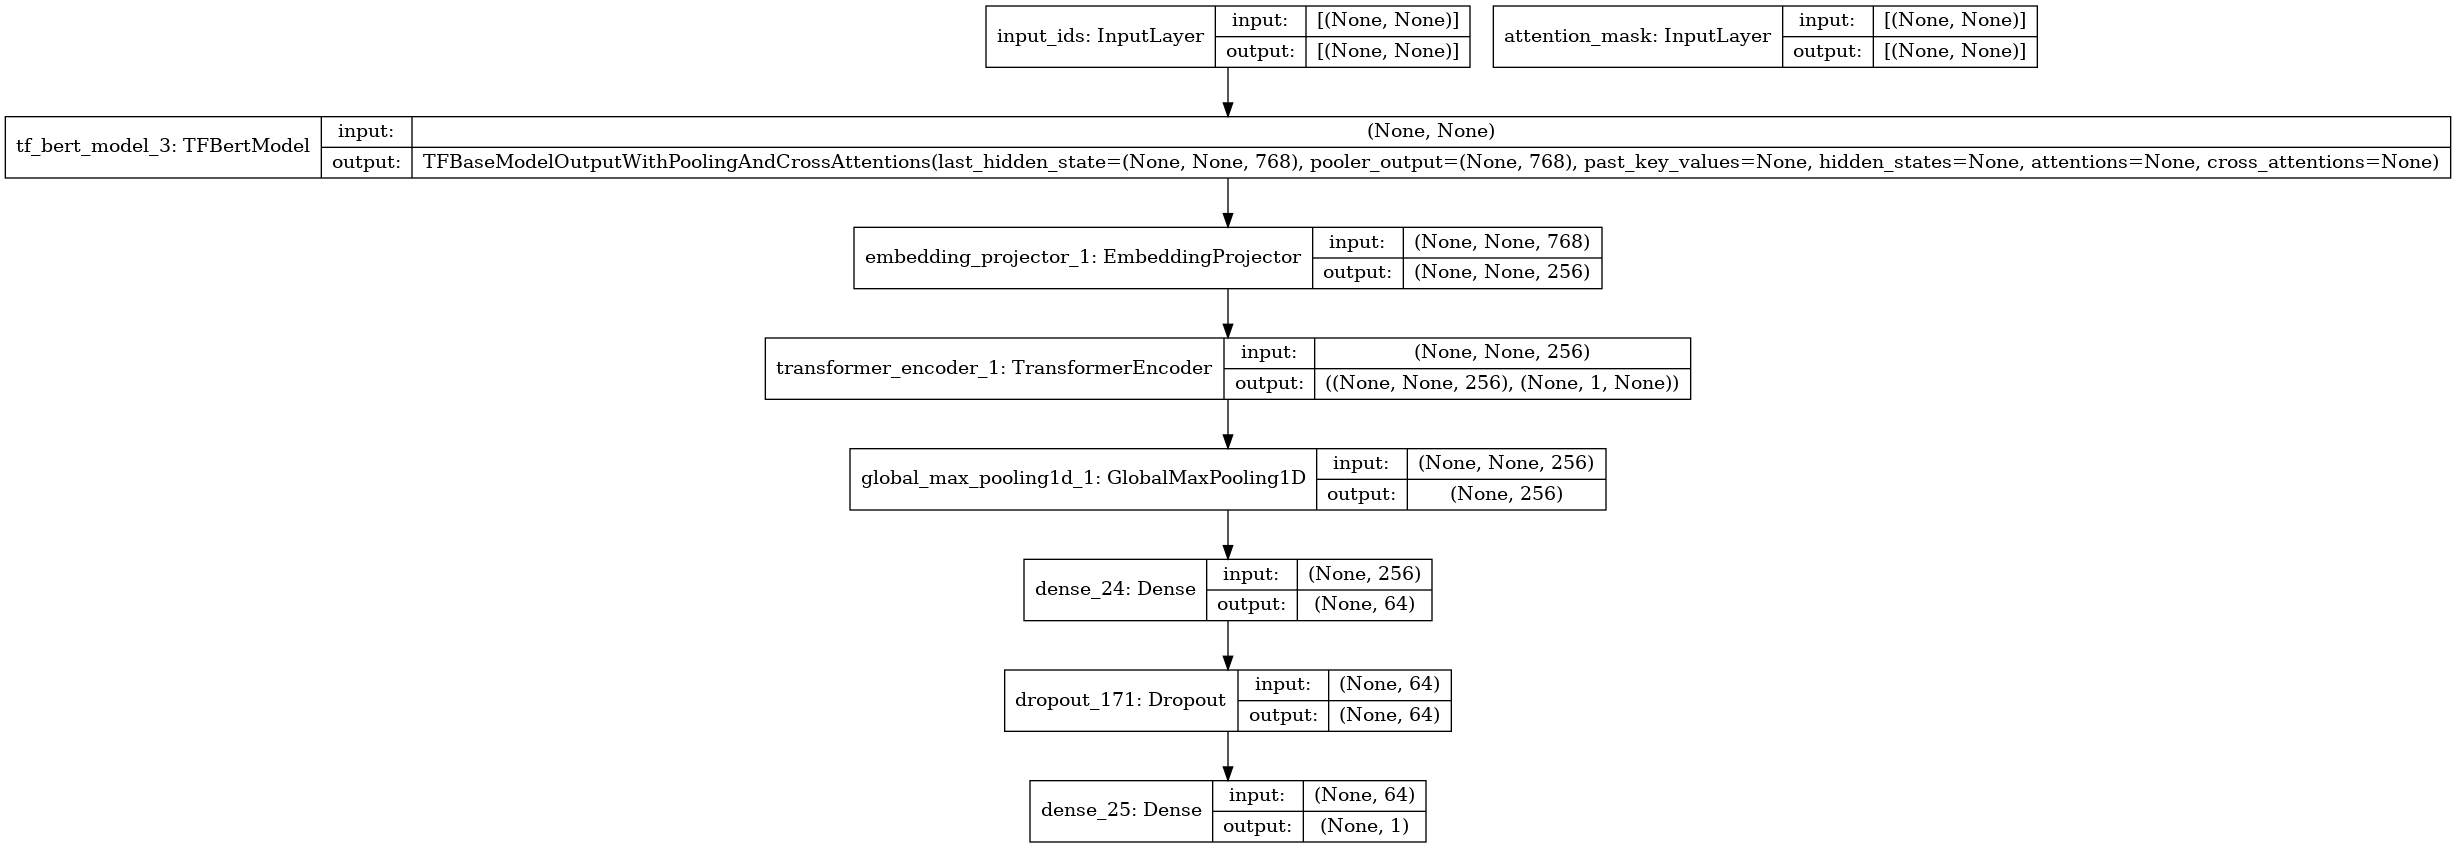

In [25]:
model_name = lang_prefix+f"TransformerEncoder{'BiLSTM' if use_lstm else ''}_{bert_names['inp']}".replace('/', '-')
print(model_name)

with strategy.scope():
    
    inp_pretrained_model = TFAutoModel.from_pretrained(**bert_params['inp']) 
    model = BertTransformerEncoder(inp_pretrained_model=inp_pretrained_model, 
                                   num_tune=num_tune, 
                                   num_projection_layers=num_projection_layers, 
                                   use_lstm=use_lstm, 
                                   nn_units=nn_units, 
                                   num_layers=num_layers, 
                                   embed_dim=embed_dim, 
                                   num_heads=num_heads,
                                   dense_dim=dense_dim,
                                   num_classes=num_classes,
                                   activation=activation, 
                                   dropout=dropout)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    display(model.build_graph().summary())
    display(tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True))

## <b> 4. Training and checkpointing <b/>

### <b> Checkpoint <b/>

In [21]:
# Record the training configurations as the name of checkpoints, logs and models to compare the different results
run_id  = f"{num_layers}layers_{num_projection_layers}projlayers_{nn_units}nnunits"
run_id += f"_{num_heads}heads_{embed_dim}embedding_{dense_dim}hidden_{dropout}dropout_{activation_name}"
run_id += f"_{init_lr}initlr_{num_warmup_steps}warmup_{optimizer._name}_tune{num_tune}layers"
run_id += f"_{GLOBAL_BATCH_SIZE}batchsize_{BUFFER_SIZE}shuffle_{num_samples}samples"
print('run_id:', run_id, '\n')

# Setup the saving path
checkpoint_path = os.path.join(DIR_CHECKPOINT, model_name+'_'+run_id, 'ckpt')
log_dir = os.path.join(DIR_LOG, model_name+'_'+run_id)

# Setup callbacks
es_metric = 'val_loss'
    
with strategy.scope():
    
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor=es_metric, save_weights_only=True, save_best_only=True, verbose=1)
    callbacks = [tensorboard, checkpoint]

    if EARLYSTOP >= 0:
        earlystopping = tf.keras.callbacks.EarlyStopping(monitor=es_metric, patience=EARLYSTOP, restore_best_weights=True, verbose=1)
        callbacks += [earlystopping]

    # If there are corresponding files, then ckpt will load and restore the status of objects
    try:
        model.load_weights(checkpoint_path)
        print(f'Restore the checkpoint at {checkpoint_path}\n')

        last_epoch = optimizer.iterations.numpy()//steps_per_epoch
        print(f'Latest checkpoint of {last_epoch} epochs restored!!')
    except:
        last_epoch = 0
        print("There is no existed checkpoint ... Start from the beginning.\n")

run_id: 4layers_2projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_3520warmup_AdamWeightDecay_tune0layers_64batchsize_8192shuffle_22500samples 

There is no existed checkpoint ... Start from the beginning.



2021-11-17 17:42:18.058461: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-17 17:42:18.058499: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-17 17:42:18.058806: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### <b> Training <b/>

In [ ]:
if colab:
    %load_ext tensorboard
    %tensorboard --logdir {DIR_LOG}

In [ ]:
history = model.fit(train_batches.repeat(EPOCHS), validation_data=valid_batches,
                    initial_epoch=last_epoch, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

## <b> 5. Model Export & Pipeline Build <b/>

### <b> Evaluation <b/>

In [18]:
%%time

loss, accuracy = model.evaluate(test_batches)

score = f"accuracy-{accuracy:.6f}-{dataset_name}"
score

391/391 [==============================] - 3908s 10s/step - loss: 0.2215 - binary_accuracy: 0.9024
CPU times: user 9h 27min 56s, sys: 1h 1min 38s, total: 10h 29min 34s
Wall time: 1h 5min 8s


'accuracy-0.902360-aclImdb'

### <b> Export <b/>

In [34]:
### Create and save the predictor

config_detail = f"{model_name}_{score}_{run_id}"
predictor = HF2TFSingleClassifierExporter(model, bert_names, config_detail, num_classes, inp_lang)
predictor_dir = os.path.join(DIR_MODEL, f"{model_name}_{score}")
tf.saved_model.save(predictor, export_dir=predictor_dir)

### Reload the pipeline to verify the result

pretrain_dir = DIR_MODELTORCH
pipeline = HF2TFClassifierPipeline(predictor_dir, pretrain_dir, text_preprocessors)

## <b> 6. Inference <b/>

In [ ]:
sentences = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'this is a bad test', 
    'and happy one is here to be classified',
    'I broke up with my...cat, help me :(:(:(',
    'movie data seems to be not enough',
    'it is definitely not bad'
]

results = pipeline(sentences, max_length=MAX_LENGTHS['inp'])
results_for_printing = [f"Input: {sentences[n]:<50} => score: {results[n][0]:.6f}"
                        for n, text in enumerate(sentences)]

print(*results_for_printing, sep='\n')